# Problem Statement

# Analysis of Ad-Hoc Communications Network

You have been asked to help with planning an ad-hoc communications network over a large rectangular region. Each individual tower can monitor a rectangular subsection of a specific width and height. The main problem is that none of the individual towers can provide coverage for the entire region of interest. Communications towers are unreliable and are put up independently and at random. You have no control over where or how big a tower’s footprint is placed. Importantly, due to technical issues such as cross-talk, no individual rectangular subsection can have multiple towers providing coverage for it. That is, there can be no overlap between any pair of rectangular subsections provided by the two respective towers. In any case, the desire is to maximize the coverage area of any available communications tower.

The order of when the towers come online is important. Once a tower has acquired its rectangular section, no subsequent tower can overlap that section. You may assume the following for this problem:

* All rectangular sections have integer-based corners.
* All rectangular sections must be contained in the overall rectangular footprint.
* The height and width of each rectangular section is sampled from a uniform distribution.
* Positions of the windows are also determined by uniform random distribution.
* All footprints must be rectangles (not general polygons).
* When a new tower comes online, if its coverage rectangle intersects the pre-existing composite footprint, then that new tower’s coverage is trimmed such that its maximum remaining coverage area is retained.

Write a detailed Jupyter notebook that implements a solution to this problem such that the user can supply the following overall size of desired coverage footprint and then determine the following:

* Given an overall desired coverage footprint and a sequence of n communications towers, what is the resulting resolved coverage?
* What is the total area of coverage relative to the desired total coverage area of the original footprint? That is, are there any gaps in coverage?
* On average, how many communications towers are required before full coverage is obtained?


# Import

### Required Module
* random
* numpy
* matplotlib 

In [74]:
import random
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mp

# Define Class

### Class definition for Region

In [78]:
class Region(object):
    '''
    Region class: Define an ad-hoc communication network and run related analysis
    
    Data:
        x_range, y_range: int, the size of rectangular overall communication network
        map: np.ndarray, the map of communication network contains coverage situation
    '''
    def __init__(self, m, n):
        '''
        Create Region with user defined size m * n.
        
        params:
            m,n: int > 0
        '''
        assert isinstance(m,int), "m must be int"
        assert isinstance(n,int), "n must be int"
        assert (m>0) and (n>0), "Please set m>0 and n>0"
        
        self.x_range = m
        self.y_range = n
        self.map = np.zeros((self.x_range,self.y_range))
        
        self.max_tower = m * n
        self.max_coverage = m * n
        self.tower = []
        self.sub_rectangle = []
        
    def show_map(self, size = 5, text = False, font_size = 10):
        '''
        Print Current Region Map
        
        params: (optional)
            size: int > 0 (self-defined figure size for output)
            text: bool (whether print index of tower or not)
            font_size: int > 0 (self-defined font size if needed to be printed)
        '''
        assert isinstance(size,int), "Size parameter must be int"
        assert isinstance(text,bool), "Please set whether show text or not as a bool parameter"
        assert isinstance(font_size,int), "font_size must be int"
        assert size>0, "Please set size>0"
        assert font_size>0, "Please set font_size>0"
        warnings.filterwarnings("ignore")
        
        # Set Basic Plot parameters
        plt.figure(figsize = (size,size))
        plt.xlim(xmin = 0, xmax = self.x_range)
        plt.ylim(ymin = 0, ymax = self.y_range)
        if self.get_tower_num() == 0: return # No tower
        
        # Plot with different color for each tower
        np.random.seed(233)
        ax = plt.subplot()
        for num in range(1,self.get_tower_num()+1):
            random_color = np.random.random(3)
            for i in range(self.x_range):
                for j in range(self.y_range):
                    if text:
                        plt.text(i+0.5,j+0.5,self.map[i,j],
                         horizontalalignment='center',
                         verticalalignment='center',
                         fontsize = font_size)
                    if self.map[i][j] == num:
                        ax.add_patch(mp.Rectangle((i, j),1,1,alpha=0.5,color=random_color,zorder = i))
        plt.show()

    def add_tower(self, x, y, size_x, size_y):
        '''
        Add new tower
        x,y is the bottom left point of the rectangular area
        
        params:
            x, y: The position of new tower
            size_x, size_y: define size of rectangular area
        '''
        assert isinstance(x,int) and isinstance(y,int), "x and y must be int"
        assert isinstance(size_x,int) and isinstance(size_y,int), "size_x and size_y must be int"
        assert x>=0 and x<self.x_range+1, "Please set 0<=x<"+str(self.x_range+1)
        assert y>=0 and y<self.y_range+1, "Please set 0<=y<"+str(self.y_range+1)
        assert size_x>0 and x+size_x<=self.x_range, "Please set size_x > 0 and x+size_x <= "+str(self.x_range)
        assert size_y>0 and y+size_y<=self.y_range, "Please set size_y > 0 and y+size_y <= "+str(self.y_range)
        
        # Get target area
        target_area = self.map[x:x+size_x, y:y+size_y]
        
        # Check blank area for new tower
        if np.sum((target_area == 0)) == 0:
            pass # No un-covered area in target area, cannot add new tower's subsection
        else:
            # Trim: find maximal blank area for adding new tower's subsection
            max_loc = self.find_max_rectangle(target_area)
            xmin, xmax, ymin, ymax = max_loc[0]+x, max_loc[1]+x, max_loc[2]+y, max_loc[3]+y

            # Add tower and its subsection
            for i in range(xmin,xmax+1):
                for j in range(ymin,ymax+1):
                    self.map[i][j] = self.get_tower_num() + 1
                    
            # Store information in class
            self.tower.append((xmin,ymin))
            self.sub_rectangle.append((xmax-xmin+1,ymax-ymin+1))
        
    def find_max_rectangle(self, np_map):
        '''
        During adding new tower
        Find max blank rectangular area for trimming

        param: 
            np_map: np.array (target area)
        return:
            maximal blank rectangular area in target area
            xmin, xmax, ymin, ymax: corresponded location
        '''
        assert isinstance(np_map,np.ndarray)
        assert len(np_map)>0, "Your target area includes nothing"

        maxArea = -1
        # Search line by line to crreate histogram
        for i in range(len(np_map)):
            row_hist = []
            
            # Count histogram and save into row_list
            for j in range(len(np_map[i])):
                if i==0: 
                    if np_map[i][j] == 0:
                        row_hist.append(1) 
                    else:
                        row_hist.append(0)
                else:
                    if np_map[i][j]!=0:
                        row_hist.append(0)
                    else:
                        # Count height for each column in one row
                        tmp = 0
                        for k in range(i,-1,-1):
                            if np_map[k][j] != 0: 
                                break
                            else:
                                tmp += 1
                        row_hist.append(tmp)

            # Get largest rectangular area in this line's histogram
            area, start_idx, height, width = self.largest_hist_area(row_hist)
            if area > maxArea:
                maxArea = area
                xmax_ref = i
                ymax_ref = start_idx
                xmin_ref = xmax_ref - height
                ymin_ref = ymax_ref - width

        # The returned value is the relative position in target area
        # Not the absolute position in map
        return xmin_ref, xmax_ref, ymin_ref, ymax_ref
    
    def largest_hist_area(self, height):
        '''
        Find the largest rectangular area in a histogram
        Used for each line in the region map
        
        param:
            height: list (each element means the height at that position)
        '''
        assert isinstance(height,list), "parameter height must be a list"
        assert len(height)>0, "height list is empty"
        
        height.append(0)
        stack = [-1]
        maxArea = 0
        save_idx = -1
        save_h = -1
        save_w = -1
        for i in range(len(height)):
            while height[i] < height[stack[-1]]:
                h = height[stack.pop()]
                w = i - stack[-1] - 1
                if h * w > maxArea:
                    maxArea = h * w
                    save_idx = i
                    save_h = h
                    save_w = w
            stack.append(i)
        height.pop()
        if maxArea == 0: return 0,0,0,0
        return maxArea, save_idx-1, save_h-1, save_w-1
        
    def get_tower_num(self):
        '''
        Get current number of tower in region
        '''
        return len(self.tower)
    
    def get_cover_area(self):
        '''
        Get current covered area
        '''
        return np.sum(self.map!=0)
        
    def auto_fill(self, max_try, n_tower, final_cover):
        '''
        Auto fill process with given number of towers and desired coverage
        
        params:
            max_try: int > 0, max number of random generating during one experiment
            n_tower: int > 0, number of towers given
            final_cover: int > 0 and <= self.max_coverage
        return:
            try_count: int, number of generating towers in one auto_fill process
        '''
        assert isinstance(max_try,int)
        assert isinstance(n_tower,int)
        assert isinstance(final_cover,int)
        assert max_try>0, "Please set max_try>0"
        assert n_tower>0, "Please set n_tower>0"
        assert final_cover>0 and final_cover<=self.max_coverage, "Please set 0<final_cover<="+str(self.max_coverage)
        
        # Start adding tower
        try_count = 0
        while try_count < max_try:
            # Check finish condition
            if self.get_tower_num() == self.max_tower: 
                #print("Fullfilled !")
                break # Already Fullfilled
            if self.get_tower_num() == n_tower: 
                #print("Reach limitation for number of towers !")
                break # Reach number of tower limitation
            if final_cover <= self.get_cover_area(): 
                #print("Meet requirement for desired coverage !")
                break # Reach desired coverage
                
            # Generate tower position and coverage randomly
            # Based on uniform distribution
            x_tmp = random.randint(0,self.x_range-1)
            y_tmp = random.randint(0,self.y_range-1)
            x_len_tmp = random.randint(1,self.x_range-x_tmp)
            y_len_tmp = random.randint(1,self.y_range-y_tmp)
            self.add_tower(x_tmp, y_tmp, x_len_tmp, y_len_tmp)
            try_count += 1
            
        return try_count
            
    def reset_map(self):
        '''
        Reset map to initial state
        Primarily used in batch expriment
        '''
        self.map = np.zeros((self.x_range,self.y_range))
        self.tower = []
        self.sub_rectangle = []
            
    def batch_experiment(self, n_exp, try_limit, tower_limit, desired_cover):
        '''
        Run n_exp times auto_fill experiment
        
        params:
            n_exp: int > 0 (number of experiment)
            try_limit: int > 0 (limitation for times of tower generation in each experiment)
            tower_limit: int > 0 (limitation for number of towers in the map of each experiment)
            desired_cover: int > 0 and <= self.max_coverage (user-defined desired coverage)
        return:
            num_try_record: list (contains times of generating towers in the map of each experiment)
            num_tower_record: list (contains final number of towers in the map of each experiment)
            coverage_record: list (contains final coverage in map of each experiment)
        '''
        assert isinstance(n_exp,int), "n_exp must be int"
        assert n_exp>0, "Please set n_exp>0"
        
        num_try_record = []
        num_tower_record = []
        coverage_record = []
        self.reset_map()
        
        for count in range(n_exp):
            n_try = self.auto_fill(try_limit, tower_limit, desired_cover)
            num_try_record.append(n_try)
            num_tower_record.append(self.get_tower_num())
            coverage_record.append(self.get_cover_area())
            self.reset_map()
            
        return num_try_record, num_tower_record, coverage_record
        
        

# Basic Example

This part will show you how to use the Region class

Build the object, define the size yourself

In [84]:
net = Region(9,9)

Add operation (Maximal Rectangle Detection included)

Tower position is defined as ```bottom left point``` of one unit rectangle area

The size of subsection for this tower is also needed

params:
    ```(x_tower, y_tower, size_x, size_y)```

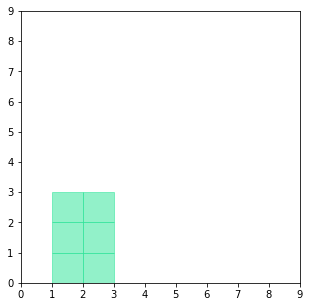

In [85]:
net.add_tower(1,0,2,3)
net.show_map()

Add another tower (No overlap situation)

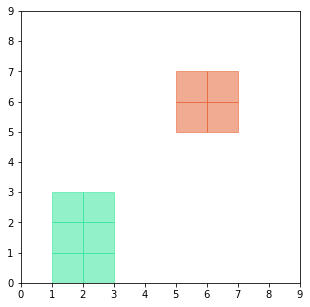

In [86]:
net.add_tower(5,5,2,2)
net.show_map()

Add another tower (Overlap Situation)

The new Rectangle area will be trimmed automatically

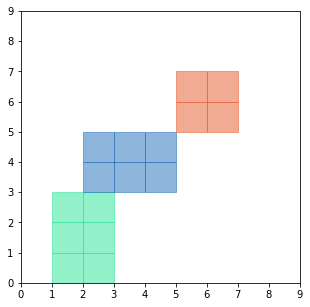

In [87]:
net.add_tower(2,2,3,3)
net.show_map()

You can also use some helpful functions to: 

* check the current number of towers with effective sub-rectangle area 
* check the current number of covered area

In [94]:
print(net.get_tower_num())
print(net.get_cover_area())

3
16


Use the reset_map function to clean up the current Region if you need

0
0


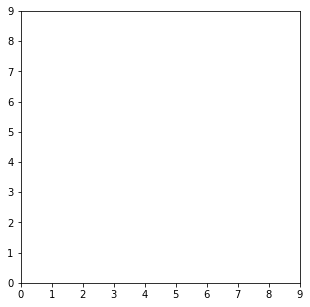

In [95]:
net.reset_map()
net.show_map()
print(net.get_tower_num())
print(net.get_cover_area())

# Automatic Example

The Region class also supports the auto add tower process and even the function for massive times of experiments

This part will show you how to use these functions

Initially define the network object

In [102]:
net = Region(8,7)

Start the auto fill process

params:
    ```(max_try, limit_num_towers, desired_cover)```

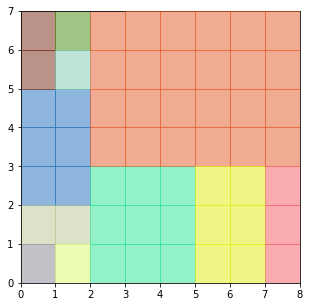

In [103]:
net.auto_fill(999,56,56) # 56 is full-covered situation for this 8*7 region network
net.show_map()

In [105]:
print(net.get_tower_num())
print(net.get_cover_area())

11
56


In [45]:
net.reset_map()

In [50]:
net.auto_fill(9999,81,81)

165

In [47]:
result = net.batch_experiment(1000,9999,81,40)

In [48]:
sum(result[2])/len(result[2])

43.696

E:\Softwares\Anaconda3\envs\py3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


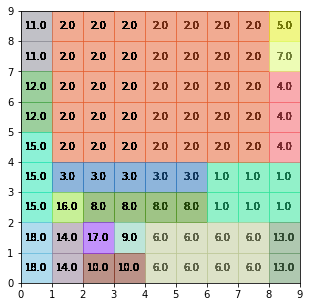

In [51]:
net.show_map(text=True)

In [41]:
net.map

array([[24., 21., 21., 27., 28., 22., 17., 17., 13.],
       [24., 19., 18., 18., 15., 15., 17., 17., 13.],
       [24., 19., 18., 18.,  1.,  8.,  8.,  8., 13.],
       [ 3.,  3., 18., 18.,  1.,  8.,  8.,  8., 11.],
       [14., 14., 14., 14.,  1.,  9.,  9.,  9.,  9.],
       [14., 14., 14., 14.,  1.,  9.,  9.,  9.,  9.],
       [23., 23., 23., 20.,  1.,  9.,  9.,  9.,  9.],
       [ 2.,  2., 26.,  4.,  4.,  4.,  6.,  6.,  6.],
       [25., 16., 16., 16., 16.,  5., 10., 12.,  7.]])

In [744]:
region = Region(9,9)
exp_result = region.batch_experiment(1000,99999,81,81)

In [747]:
sum(exp_result[0])/len(exp_result[0])

123.676

In [738]:
map1 = Region(9,9)
map1.auto_fill(9999999999,81,81)


85

In [723]:
map1.get_tower_num()

16

In [724]:
map1.get_cover_area()

81

E:\Softwares\Anaconda3\envs\py3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


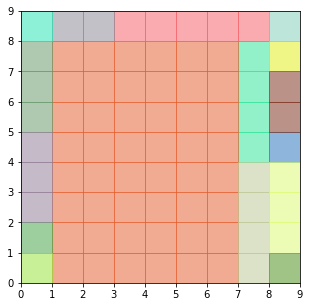

In [726]:
map1.show_map()